In [1]:
import torch
import os
import umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

c:\Users\hqhz1\anaconda3\envs\datathon\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.getcwd()

'd:\\Datathon\\eda'

In [3]:
stats_dict = torch.load(r'../checkpoints/golf_pose_stats_120ft.pt', map_location='cpu', weights_only=False)
dt = np.array(stats_dict['table'])

In [4]:
mean = dt.mean(axis=0)
std = dt.std(axis=0)
dt = (dt - mean) / (std + 1e-8)

In [7]:
IN_DIR = '../test/TDTU-Golf-Pose-v1_120ft'

train_rows = []

for i in range(dt.shape[0]):
	train_rows.append({
		'embedding': dt[i],   # shape (40,)
		'band': np.nan,        # train không có band
		'place': np.nan,
		'angle': np.nan
	})

train_table = pd.DataFrame(train_rows)
test_rows = []

for root, _, files in os.walk(IN_DIR):
	for fname in files:
		in_path = os.path.join(root, fname)
		rel_path = os.path.relpath(in_path, IN_DIR)

		embedding = torch.load(
			in_path,
			map_location='cpu',
			weights_only=False
		)

		embedding = (embedding - mean) / (std + 1e-8)

		test_rows.append({
			'embedding': embedding,
			'band': rel_path.split(os.sep)[-2],
			'place': rel_path.split(os.sep)[-3],
			'angle': 'back' if 'Backside' in rel_path else 'side'
		})

test_table = pd.DataFrame(test_rows)
table = pd.concat([train_table, test_table], ignore_index=True)


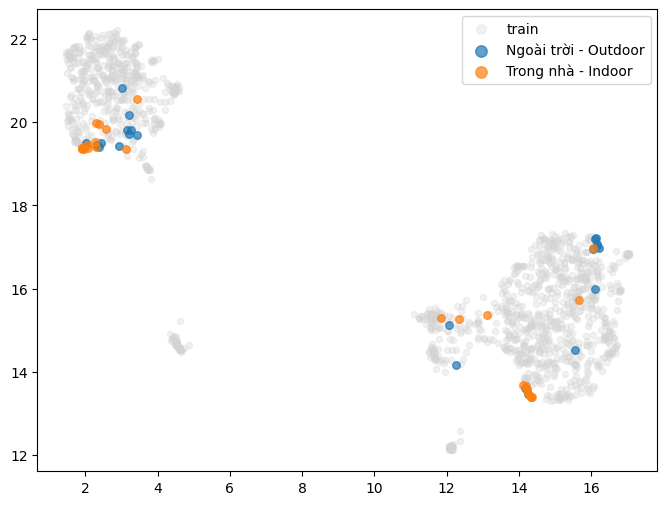

In [13]:
X = np.stack(table['embedding'].values)

reducer = umap.UMAP(n_components=2)
X_umap = reducer.fit_transform(X)
table['u1'] = X_umap[:, 0]
table['u2'] = X_umap[:, 1]

bands = table['band'].dropna().unique()
places = table['place'].dropna().unique()
angles = table['angle'].dropna().unique()

plt.figure(figsize=(8, 6))

train_subset = table[table['band'].isna()]

plt.scatter(
	train_subset['u1'],
	train_subset['u2'],
	c='lightgray',
	alpha=0.3,
	s=20,
	label='train'
)
for band in places:
	subset = table[table['place'] == band]
	plt.scatter(
		subset['u1'],
		subset['u2'],
		label=band,
		alpha=0.7,
		s=30
	)
plt.legend(markerscale=1.5)

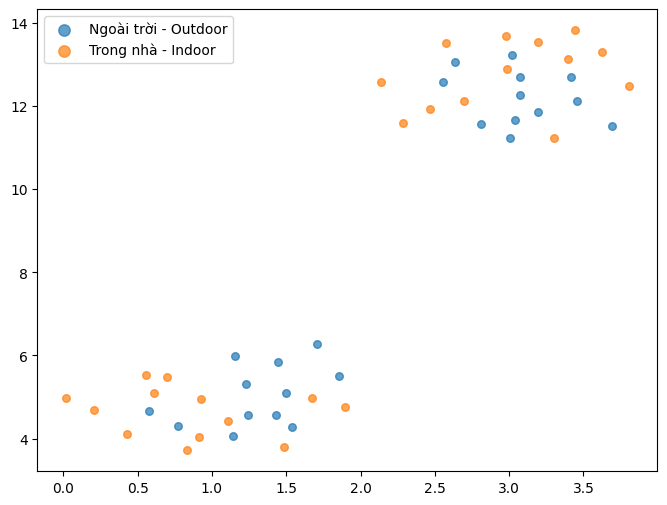

In [14]:
test_subset = test_table.copy()
X = np.stack(test_subset['embedding'].values)
reducer = umap.UMAP(n_components=2)
X_umap = reducer.fit_transform(X)
test_table['u1'] = X_umap[:, 0]
test_table['u2'] = X_umap[:, 1]

bands = test_table['band'].dropna().unique()
places = test_table['place'].dropna().unique()
angles = test_table['angle'].dropna().unique()
plt.figure(figsize=(8, 6))
for angle in places:
	subset = test_table[test_table['place'] == angle]
	plt.scatter(
		subset['u1'],
		subset['u2'],
		label=angle,
		alpha=0.7,
		s=30
	)
plt.legend(markerscale=1.5)